# Download the data from Kaggle and extract the files.

In [2]:
import os
os.environ["PATH"] += os.pathsep + os.path.expanduser("~/.local/bin")
os.environ["PYTHONPATH"] += os.pathsep + os.path.expanduser("~/.local/lib/python3.11/site-packages")

In [23]:
!kaggle datasets download -d jeffsinsel/nyc-fhvhv-data --path ~/kaggle_test/

Dataset URL: https://www.kaggle.com/datasets/jeffsinsel/nyc-fhvhv-data
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 17.8G/17.8G [09:36<00:00, 40.8MB/s]
100%|██████████████████████████████████████| 17.8G/17.8G [09:36<00:00, 33.3MB/s]


In [4]:
!kaggle datasets download -d salikhussaini49/nyc-tlc-trip-record-data-repository --path ~/kaggle_test/

... resuming from 18447597568 bytes (39723556602 bytes left) ...
100%|█████████████████████████████████████▉| 54.2G/54.2G [30:06<00:00, 29.3MB/s]
100%|██████████████████████████████████████| 54.2G/54.2G [30:06<00:00, 22.0MB/s]


In [1]:
!kaggle datasets download -d salikhussaini49/nyc-tlc-trip-record-data-repository --path ~/kaggle_test/ --force


/bin/bash: line 1: kaggle: command not found


In [ ]:
!unzip ~/kaggle_test/nyc-tlc-trip-record-data-repository.zip -d ~/kaggle_test/data2


Archive:  /home/sseo/kaggle_test/nyc-tlc-trip-record-data-repository.zip
  inflating: /home/sseo/kaggle_test/data2/data_shape_2.csv  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-01.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-02.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-03.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-04.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-05.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-06.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-07.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-08.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-09.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-10.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-11.parquet  
  inflating: /home/sseo/kaggle_test/data2/fhv_tripdata_2015-12.

# Goal Of this Part: 
During this project, I aim to examine how pricing policies differ across taxi companies.

As a simple approach, I plan to analyze how fares are determined based on trip distance for each company (excluding tips). The slope of the line between distance and fare will serve as an indicator: the steeper the slope, the more expensive the company's pricing policy can be considered.

## 1. Library Loading

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max
import glob
from pyspark.sql.functions import col
import pandas as pd
from pyspark.sql.functions import when
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression



## 2. Data Loading
(Beacuse of limitation of the Capacity of the memory, I just used only 3 parquets for this project)

In [16]:
spark = SparkSession.builder \
    .appName("FHVHV Trip Data Analysis") \
    .getOrCreate()

file_list = sorted(glob.glob("./data1/fhvhv_tripdata_*.parquet"))[:3]
df = spark.read.parquet(*file_list)

print("total row:", df.count())

total row: 65758522


## 3. Data Preprocessing
1) Mapping taxi company codes to their names:
"HV0002": "Juno",
"HV0003": "Uber",
"HV0004": "Via",
"HV0005": "Ly
   

In [17]:
df = df.withColumn(
    "company",
    when(df["hvfhs_license_num"] == "HV0002", "Juno")
    .when(df["hvfhs_license_num"] == "HV0003", "Uber")
    .when(df["hvfhs_license_num"] == "HV0004", "Via")
    .when(df["hvfhs_license_num"] == "HV0005", "Lyft")
    .otherwise("Other")  
)

2. Perform numeric preprocessing to calculate the total amount.

In [18]:
df = df.fillna({
    "base_passenger_fare": 0,
    "tolls": 0,
    "bcf": 0,
    "sales_tax": 0,
    "congestion_surcharge": 0,
    "airport_fee": 0,
    "tips": 0
})

3. Define the maximum values for distance and fare in order to calculate total_amount and compare the data.
- max distance : 10 miles

In [19]:
df = df.withColumn("total_amount",
    col("base_passenger_fare") +
    col("tolls") +
    col("bcf") +
    col("sales_tax") +
    col("congestion_surcharge") +
    col("airport_fee"))
#Sample the data to improve visualization performance.
df_sample = df.select("company", "trip_miles", "total_amount")

df_pd = df_sample.sample(fraction=0.05).toPandas()
df_pd= df_pd[df_pd['trip_miles']<=10]
df_pd= df_pd[df_pd['total_amount']<=50]

# 4. Data visualization
1. Looking at the boxplot, Via appears to have the lowest median fare, suggesting it is relatively inexpensive. The fare range also seems more limited compared to others, although it shows large outliers.
2. 

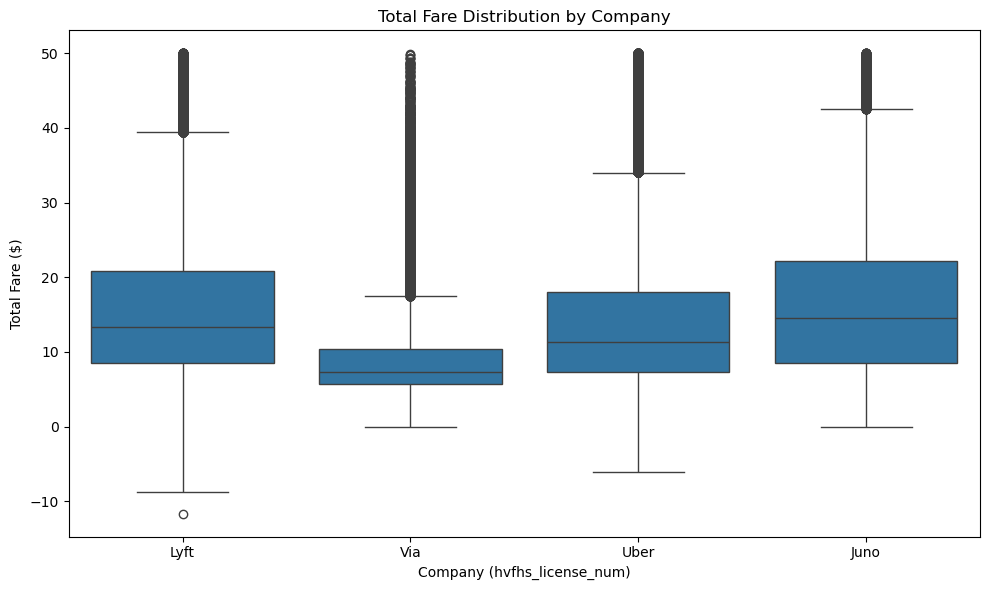

In [20]:

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_pd,
    x="company",   
    y="total_amount"  
)
plt.title("Total Fare Distribution by Company")
plt.xlabel("Company (hvfhs_license_num)")
plt.ylabel("Total Fare ($)")
plt.tight_layout()
plt.show()


# Result 
Based on the results, the lowest cost per mile was observed in the order of
Via > Uber > Lyft > Juno.
(However, in the case of Via, most of the data is concentrated around shorter trip distances, so this should be taken into account when comparing prices.)
The relatively low R² scores for Via and Uber suggest that although their fares are lower, the fare variability is higher.

In [26]:
for company in df_pd["company"].unique():
    print(f"Company: {company}")
    
    company_df = df_pd[df_pd["company"] == company]
    
    # Input: X (distance), Output: y (fare)
    X = company_df["trip_miles"].values.reshape(-1, 1)
    y = company_df["total_amount"].values

    # Model training
    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(X, y)

    # Predict on training set
    y_pred = rf.predict(X)

    # Evaluation metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Print results
    print(f"  R² score: {r2:.4f}")
    print(f"  RMSE: ${rmse:.2f}")

    # Show a few sample predictions
    for xi, yi, y_hat in zip(X[:5].flatten(), y[:5], y_pred[:5]):
        print(f"    trip_miles: {xi:.2f}, actual: ${yi:.2f}, predicted: ${y_hat:.2f}")
    
    print("-" * 50)


Company: Lyft
  R² score: 0.6096
  RMSE: $5.80
    trip_miles: 1.15, actual: $5.48, predicted: $8.81
    trip_miles: 6.38, actual: $21.05, predicted: $26.87
    trip_miles: 5.28, actual: $22.74, predicted: $23.57
    trip_miles: 1.82, actual: $25.56, predicted: $11.34
    trip_miles: 2.42, actual: $10.95, predicted: $13.36
--------------------------------------------------
Company: Via
  R² score: 0.4924
  RMSE: $3.62
    trip_miles: 4.63, actual: $7.89, predicted: $10.53
    trip_miles: 1.59, actual: $8.71, predicted: $6.44
    trip_miles: 5.09, actual: $9.74, predicted: $13.12
    trip_miles: 7.75, actual: $16.88, predicted: $17.63
    trip_miles: 6.04, actual: $8.66, predicted: $14.06
--------------------------------------------------
Company: Uber
  R² score: 0.3910
  RMSE: $7.06
    trip_miles: 6.59, actual: $7.13, predicted: $21.84
    trip_miles: 2.20, actual: $6.24, predicted: $11.32
    trip_miles: 1.37, actual: $4.54, predicted: $8.84
    trip_miles: 2.67, actual: $12.32, pre

In [27]:
for company in df_pd["company"].unique():
    company_df = df_pd[df_pd["company"] == company]
    
    X = company_df["trip_miles"].values.reshape(-1, 1)
    y = company_df["total_amount"].values

    # Train linear regression model
    lr = LinearRegression()
    lr.fit(X, y)

    # Get slope, intercept, and performance metrics
    slope = lr.coef_[0]                     # Slope = cost per mile
    intercept = lr.intercept_               # Intercept = estimated base fare
    y_pred = lr.predict(X)                  # Predicted values
    r2 = lr.score(X, y)                     # R² score on training data
    rmse = np.sqrt(mean_squared_error(y, y_pred))  # Root Mean Squared Error

    # Output results
    print(f"{company}")
    print(f"  Slope (cost per mile): ${slope:.2f} per mile")
    print(f"  Intercept (estimated base fare): ${intercept:.2f}")
    print(f"  R² score (train): {r2:.4f}")
    print(f"  RMSE: ${rmse:.2f}")
    print("-" * 40)

Lyft
  Slope (cost per mile): $3.18 per mile
  Intercept (estimated base fare): $5.70
  R² score (train): 0.6047
  RMSE: $5.84
----------------------------------------
Via
  Slope (cost per mile): $1.73 per mile
  Intercept (estimated base fare): $3.62
  R² score (train): 0.4728
  RMSE: $3.69
----------------------------------------
Uber
  Slope (cost per mile): $2.49 per mile
  Intercept (estimated base fare): $5.81
  R² score (train): 0.3887
  RMSE: $7.08
----------------------------------------
Juno
  Slope (cost per mile): $3.32 per mile
  Intercept (estimated base fare): $6.45
  R² score (train): 0.6174
  RMSE: $5.95
----------------------------------------


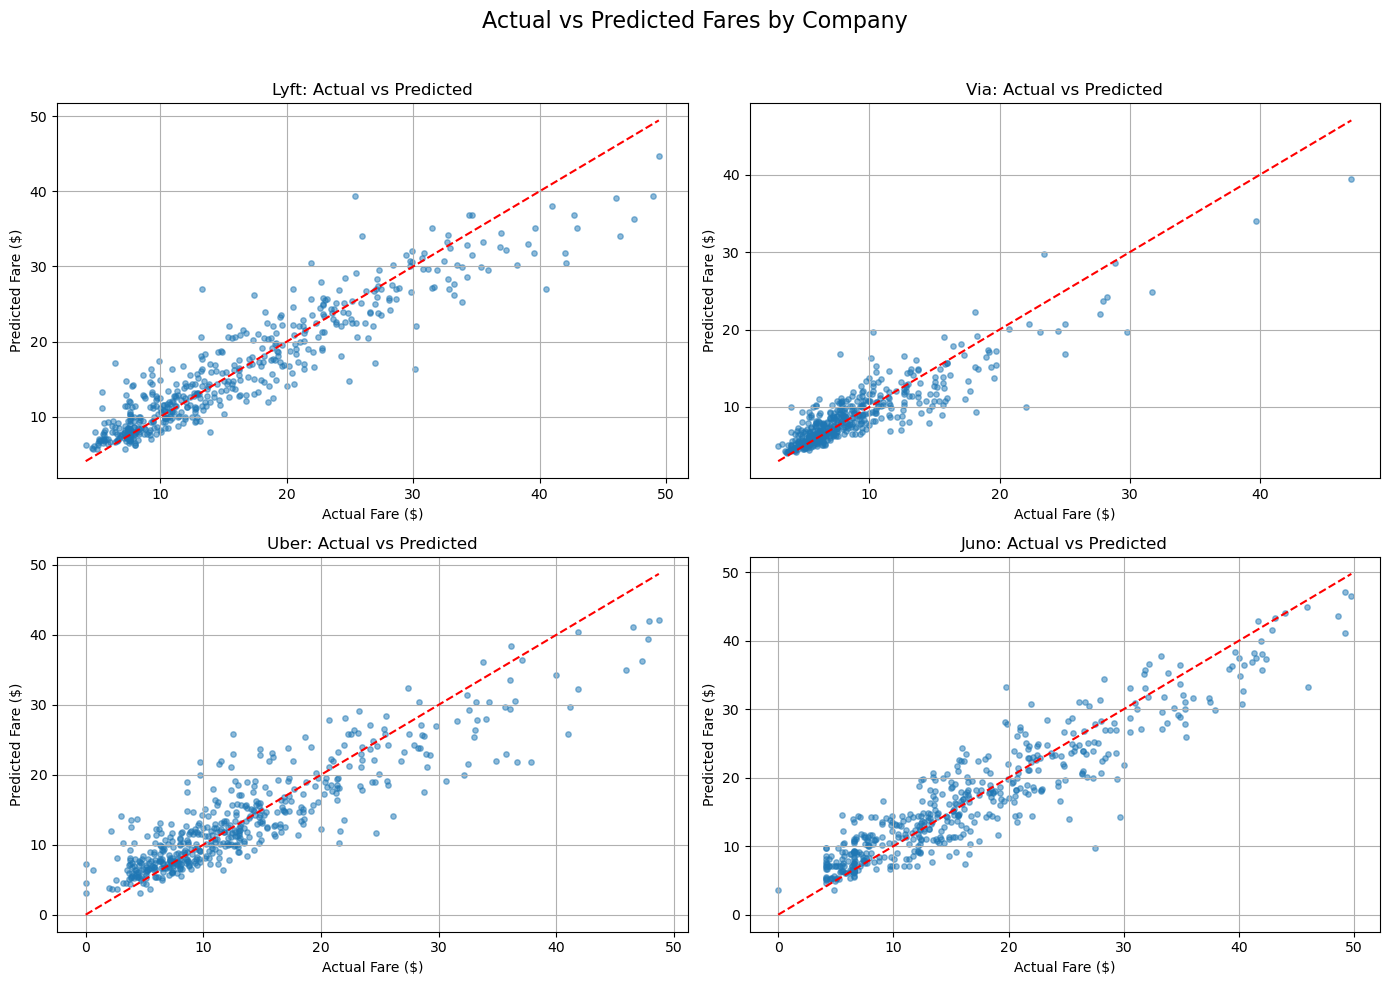

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, company in enumerate(df_pd["company"].unique()):
    company_df = df_pd[df_pd["company"] == company].sample(n=500, random_state=42)

    X = company_df["trip_miles"].values.reshape(-1, 1)
    y = company_df["total_amount"].values

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X, y)
    y_pred = model.predict(X)

    axs[i].scatter(y, y_pred, alpha=0.5, s=15)
    axs[i].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  
    axs[i].set_title(f"{company}: Actual vs Predicted")
    axs[i].set_xlabel("Actual Fare ($)")
    axs[i].set_ylabel("Predicted Fare ($)")
    axs[i].grid(True)

plt.suptitle("Actual vs Predicted Fares by Company", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Conclusion :
In this model, the analysis focused solely on the relationship between distance and fare across the four taxi companies. However, in the future, I believe a more complex and multidimensional analysis can be conducted by leveraging additional features available in the dataset.

Possible improvements:
- Increase the volume of data used,
- Analyze the data across different time periods,
- Conduct statistical comparisons between companies.